# Tdsm encoder (Toy Model)
This section is made for quickly experimenting new idea and getting understand the whole structure. Working on SWAN is recommanded. You can utilize GPU by entering the node [SWAN](https://swan-k8s.cern.ch) and choose `Software stack=102b Cuda 11.7.1(GPU)` to configure environment(Probably need to open the ticket to get the access).

## Import module

In [10]:

!pip3 install tqdm
!pip3 install ipywidgets
! jupyter --
!pip3 install ipywidgets widgetsnbextension pandas-profiling
!jupyter nbextension enable --py widgetsnbextension
!pip install pytorch-ignite

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: bundlerextension dejavu execute kernel kernelspec lab
labextension labhub migrate nbclassic nbconvert nbextension notebook qtconsole
run server serverextension troubleshoot trust

Please specify a subcommand or one of the optional arguments.


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 321.1 kB/s eta 0:00:00m eta 0:00:010:01:01


In [1]:
import time, functools, torch, os, random, utils, fnmatch, psutil, argparse
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nnz
import torch.nn.functional as F
from torch.optim import Adam, Adamax
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from trans_tdsm import Gen, loss_fn, pc_sampler
import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D

## Configuration

In [2]:
workingdir = "./"
print('torch version: ', torch.__version__)
global device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running on device: ', device)
if torch.cuda.is_available():
    print('Cuda used to build pyTorch: ',torch.version.cuda)
    print('Current device: ', torch.cuda.current_device())
    print('Cuda arch list: ', torch.cuda.get_arch_list())

print('Working directory: ', workingdir)


torch version:  2.0.1
Running on device:  cpu
Working directory:  ./


## Generate Toy Model (Option)
Generate toy events. The result will be stored in `dataset/toy_model.pt`. The result is in the form of [List(Events(torch.tensor(max_hit, nfeatures)), injection energy(1D torch.tensor)].

In [3]:
from toy_generator import generate_event
result = generate_event(max_energy=200, nevent=20000, nlayer=5)
print("max number of hits", result[0][0].shape[0])
print("nfeatures", result[0][0].shape[1])
print("nEvents", result[1].shape[0])

max number of hits 150
nfeatures 4
nEvents 20000


## Demonstrate Event (Option)

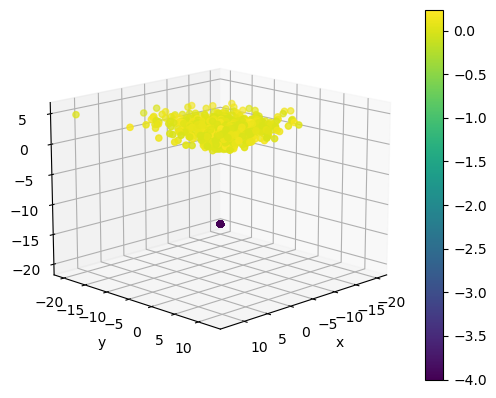

In [5]:
from display_result import display_result
display_result(nevent=10)

## Load dataset (Try until it works)
SWAN seems to easily fail to load dataset to GPU, so need to run this cell several times until it succeeds. Experience shows O(3~4) times is needed.

In [18]:
from copy import deepcopy
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer


qt = QuantileTransformer(n_quantiles=5, random_state=0)
# You may need to run several times until it succeeds.
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

vesde = utils.VESDE(device=device)
batch_size = 150

new_marginal_prob_std_fn = functools.partial(vesde.marginal_prob)
new_diffusion_coeff_fn   = functools.partial(vesde.sde)

training_file_path = 'dataset/toy_model.pt'
filename = training_file_path
loaded_file = torch.load(filename, map_location=torch.device(device))

inject_energy = loaded_file[1]
events        = loaded_file[0]

training_dataset = events[:10000]
training_inject_energy = inject_energy[:10000]
#print(training_inject_energy)
testing_dataset  = events[10000:]
testing_inject_energy  = inject_energy[10000:]
counter=0

#hello=torch.tensor()



global original_energy
original_energy = []
global original_x 
original_x = []
global original_y 
original_y = []
global original_z 
original_z= []



for i, data in enumerate(training_dataset,0):
        
        valid_event = []
        data_np   = data.cpu().numpy().copy()
        #energy_np = energy.cpu().numpy().copy()
        mask = data_np[:,3] > 0.5
        valid_event = data_np[mask]

        if len(valid_event) == 0:
            continue
        valid_event = np.array(valid_event)
        
        original_energy += deepcopy((valid_event)[:,0]).flatten().tolist()
        original_x += deepcopy((valid_event)[:,1]).flatten().tolist()
        original_y += deepcopy((valid_event)[:,2]).flatten().tolist()
        original_z += deepcopy((valid_event)[:,3]).flatten().tolist()
        #data[:,0] = torch.Tensor((valid_event)[:,0].flatten())
        #data[:,1] = torch.Tensor((valid_event)[:,1].flatten())
        #data[:,2] = torch.Tensor((valid_event)[:,2].flatten())
        #data[:,3] = torch.Tensor((valid_event)[:,3].flatten())
        
        



# print(torch.Tensor(training_dataset[:][:][0][1]).reshape(-1,1))       
# hello=torch.cat(training_dataset)
# yellow=trans_e.fit(torch.Tensor(training_dataset[:][:][0][1]).reshape(-1,1))
# blue=yellow.transform(training_dataset[:][:][0][1].reshape(-1,1))
# print(blue)
# hello[:,0]=torch.Tensor(trans_e.fit_transform(hello[:,0].reshape(-1,1))).flatten()
# hello[:,1]=torch.Tensor(trans_x.fit_transform(hello[:,1].reshape(-1,1))).flatten()
# hello[:,2]=torch.Tensor(trans_y.fit_transform(hello[:,2].reshape(-1,1))).flatten()
# hello[:,3]=torch.Tensor(trans_z.fit_transform(hello[:,3].reshape(-1,1))).flatten()

# op=hello.chunk(1000)
# print(op)
# print(hello[:,0])
# print(hello.size()[0])

# training_dataset=op
#print(len(really))
#really=np.array(really)
#print(really)
#print(type(really))
#print(really[:,0])
    
# print(type(a))

        
#dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=False)
print("I am done")

I am done


## Summarize training samples

this is new
tensor([[0.0413],
        [0.0170],
        [0.0236],
        ...,
        [0.0225],
        [0.1148],
        [0.0328]])


/var/folders/x6/498jm63x7n97h38ldfpdrspr0000gn/T/ipykernel_66292/358542774.py:169: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


703608
tensor([[ 4.1287e-02,  4.9725e-01,  5.1863e-01,  0.0000e+00],
        [ 1.6974e-02,  4.8309e-01,  5.2419e-01,  0.0000e+00],
        [ 2.3586e-02,  5.0150e-01,  4.6497e-01,  0.0000e+00],
        [ 9.7368e-02,  5.0953e-01,  5.2228e-01,  2.5000e-01],
        [ 1.0137e-01,  5.4595e-01,  5.3346e-01,  2.5000e-01],
        [ 3.6912e-02,  5.3504e-01,  4.5946e-01,  2.5000e-01],
        [ 9.5422e-02,  5.1677e-01,  4.4527e-01,  2.5000e-01],
        [ 8.5199e-02,  4.8315e-01,  5.2407e-01,  2.5000e-01],
        [ 4.4899e-02,  4.0750e-01,  4.7679e-01,  2.5000e-01],
        [ 3.3538e-02,  4.5276e-01,  5.6660e-01,  2.5000e-01],
        [ 1.1140e-02,  4.4689e-01,  4.9078e-01,  2.5000e-01],
        [ 2.1714e-02,  4.3019e-01,  4.7133e-01,  2.5000e-01],
        [ 1.9602e-03,  4.5637e-01,  4.9788e-01,  2.5000e-01],
        [ 6.1795e-02,  4.8614e-01,  5.6203e-01,  2.5000e-01],
        [ 4.4534e-02,  4.8327e-01,  5.1382e-01,  2.5000e-01],
        [ 1.0428e-01,  3.9921e-01,  5.1811e-01,  2.5000e-01],
 

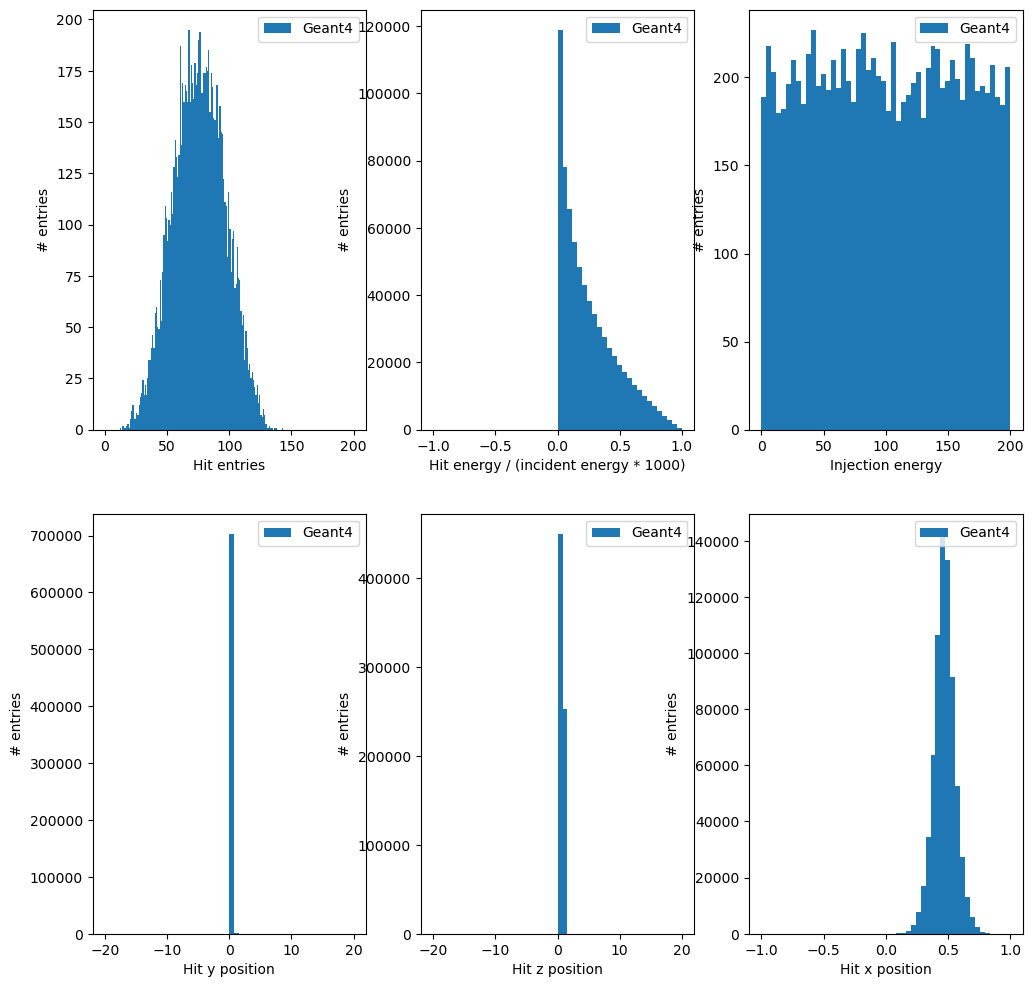

In [21]:
#from display_result import summarize_result

import numpy as np
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=5, random_state=0)

def summarize_result(samples, energy, threshold= 0.1, label = ""):
    
    global all_x 

    all_x = []
    global all_y 
    all_y = []
    global all_z 
    all_z = []
    global all_e 
    all_e = []
    entries = []
    inject_energy = []
    lin=np.linspace(0,20,10000,endpoint=True)
    print("this is new")
    global all_x_tensor
    all_x_tensor = np.array([])
    global all_y_tensor
    all_y_tensor = np.array([])
    global all_z_tensor
    all_z_tensor = np.array([])
    global all_e_tensor
    all_e_tensor = np.array([])
    global dataset_transformed
    dataset_transformed = np.array([])
    global dataset_transformed_list
    dataset_transformed_list = []

    for i, data in enumerate(samples,0):
        
        valid_event = []
        data_np   = data.cpu().numpy().copy()
        energy_np = energy.cpu().numpy().copy()
        mask = data_np[:,3] > threshold
        valid_event = data_np[mask]

        if len(valid_event) == 0:
            continue
        valid_event = np.array(valid_event)
        
        #print(valid_event.shape[0])
        
        
        all_e_tensor = np.append(all_e_tensor,((valid_event).copy()[:,0]).reshape(-1,1))
        all_x_tensor = np.append(all_x_tensor,((valid_event).copy()[:,1]).reshape(-1,1))
        all_y_tensor = np.append(all_y_tensor,((valid_event).copy()[:,2]).reshape(-1,1))
        all_z_tensor = np.append(all_z_tensor,((valid_event).copy()[:,3]).reshape(-1,1))
        entries.append(len(valid_event))
        inject_energy.append(energy_np[i])
        
    
    all_e_tensor =torch.Tensor(all_e_tensor).reshape(-1,1)
    #print(all_e_tensor)
    all_x_tensor =torch.Tensor(all_x_tensor).reshape(-1,1)
    all_y_tensor =torch.Tensor(all_y_tensor).reshape(-1,1)
    all_z_tensor =torch.Tensor(all_z_tensor).reshape(-1,1)
    
    global transform_e
    global transform_x
    global transform_y
    global transform_z

    transform_e = MinMaxScaler().fit(all_e_tensor) 
    transform_x = MinMaxScaler().fit(all_x_tensor)
    transform_y = MinMaxScaler().fit(all_y_tensor)
    transform_z = MinMaxScaler().fit(all_z_tensor)

    
    for showers in training_dataset:
        pad_hits = result[0][0].shape[0]-showers.shape[0]
        E_ = np.asarray(showers[:,0]).reshape(-1, 1)
        X_ = np.asarray(showers[:,1]).reshape(-1, 1)
        Y_ = np.asarray(showers[:,2]).reshape(-1, 1)
        Z_ = np.asarray(showers[:,3]).reshape(-1, 1)
        E_ = transform_e.transform(E_)
        X_ = transform_x.transform(X_)
        Y_ = transform_y.transform(Y_)
        Z_ = transform_z.transform(Z_)
        E_ = torch.from_numpy( E_.flatten() )
        X_ = torch.from_numpy( X_.flatten() )
        Y_ = torch.from_numpy( Y_.flatten() )
        Z_ = torch.from_numpy( Z_.flatten() )
        shower_data_transformed = torch.stack((E_,X_,Y_,Z_), -1)
        padded_shower = F.pad(input = shower_data_transformed, pad=(0,0,0,pad_hits), mode='constant', value=-20)
        dataset_transformed_list.append(padded_shower)
        #padded_shower = F.pad(input = shower_data_transformed, pad=(0,0,0,pad_hits), mode='constant', value=-20)
        #padded_showers.append(padded_shower)
        #shower_count+=1
        
        
    all_e_tensor = torch.Tensor(transform_e.transform(all_e_tensor))
    print(all_e_tensor)
    #all_x_tensor = torch.Tensor(transform_x.transform(all_x_tensor))
    #all_y_tensor = torch.Tensor(transform_y.transform(all_y_tensor))
    #all_z_tensor = torch.Tensor(transform_z.transform(all_z_tensor))

    #print(all_e_tensor.shape)
    
    #dataset_transformed=torch.stack((all_e_tensor,all_x_tensor,all_y_tensor,all_z_tensor), -1)
    #print(dataset_transformed_list[0])
    #training_dataset=dataset_transformed

    
    #dataset_transformed=torch.Tensor(dataset_transformed)
    for i, data in enumerate(dataset_transformed_list,0):
        
        valid_event = []
        data_np   = data.cpu().numpy().copy()
        energy_np = energy.cpu().numpy().copy()
        mask = data_np[:,3] > 0.1
        valid_event = data_np[mask]

        if len(valid_event) == 0:
            continue
        valid_event = np.array(valid_event)
        
        #print(valid_event.shape[0])
        
        all_e += ((valid_event).copy()[:,0]).flatten().tolist()
        all_x += ((valid_event).copy()[:,1]).flatten().tolist()
        all_y += ((valid_event).copy()[:,2]).flatten().tolist()
        all_z += ((valid_event).copy()[:,3]).flatten().tolist()
        
        
        
    
    #all_x=trans_x.inverse_transform(torch.Tensor(all_x).reshape(-1,1)).flatten().tolist()
    fig, ax = plt.subplots(2,3, figsize=(12,12))

    ax[0][0].set_ylabel('# entries')
    ax[0][0].set_xlabel('Hit entries')
    ax[0][0].hist(entries, 200, range=(0,200), label=label)
    ax[0][0].legend(loc='upper right')

    ax[0][1].set_ylabel('# entries')
    ax[0][1].set_xlabel('Hit energy / (incident energy * 1000)')
    ax[0][1].hist(all_e, 50, range=(-1,1), label=label)
    ax[0][1].legend(loc='upper right')

    ax[0][2].set_ylabel('# entries')
    ax[0][2].set_xlabel('Injection energy')
    ax[0][2].hist(inject_energy, 50, range=(0,200), label=label)
    ax[0][2].legend(loc='upper right')

    ax[1][2].set_ylabel('# entries')
    ax[1][2].set_xlabel('Hit x position')
    ax[1][2].hist(all_x, 50, range=(-1,1), label=label)
    #ax[1][2].hist(original_x[:182574], 50, range=(-20,20), color='red')
    ax[1][2].legend(loc='upper right')

    ax[1][0].set_ylabel('# entries')
    ax[1][0].set_xlabel('Hit y position')
    ax[1][0].hist(all_y, 50, range=(-20,20), label=label)
    #ax[1][0].hist(original_y[:182590], 50, range=(-20,20), color='red')
    ax[1][0].legend(loc='upper right')

    ax[1][1].set_ylabel('# entries')
    ax[1][1].set_xlabel('Hit z position')
    ax[1][1].hist(all_z, 50, range=(-20,20), label=label)
    #ax[1][1].hist(original_z[:182559], 50, range=(-20,20), color='red')
    ax[1][1].legend(loc='upper right')
    fig.show()
    fig.savefig("test.png")
summarize_result(training_dataset, training_inject_energy, threshold=0.5, label = "Geant4")
print(len(all_x))
training_dataset=dataset_transformed_list
output_directory = os.path.join(workingdir, 'sampling')

#training_dataset=dataset_transformed
dataloader = DataLoader(dataset_transformed_list, batch_size=batch_size, shuffle=False)

training_dataset=dataset_transformed_list
print(dataset_transformed_list[0])
#torch.save(dataset_transformed, os.path.join(output_directory,'0728RobustScalar_training_samples.pt'))

## Training

  0%|          | 0/200 [00:00<?, ?it/s]

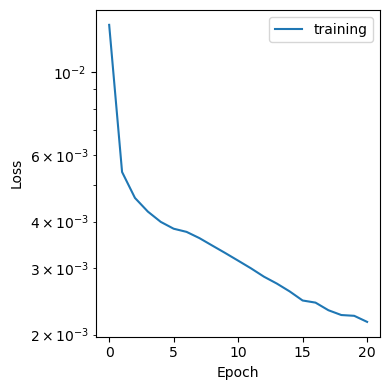

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

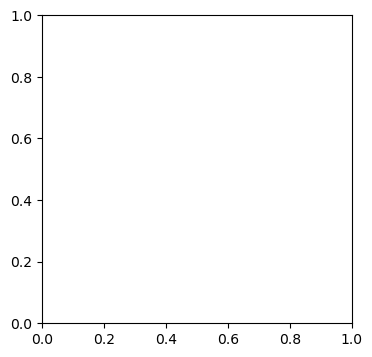

In [22]:
import tqdm
from tqdm import tqdm_notebook
from IPython import display
import torch.nn as nn
from Conv4d import Conv4d


%matplotlib inline
plt.gcf().canvas.draw()

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
output_directory = os.path.join(workingdir, 'training_result')
os.system(f'mkdir -p {output_directory}')

lr = 0.0001
n_epochs = 200




model = Gen(4, 200, 128, 3, 1, 0, marginal_prob_std=new_marginal_prob_std_fn)
#print(model.shape)
#model =CNNnet(4,4)
#model=CNNnet()

#model = net(input)

#print('model: ', model)

optimiser = torch.optim.Adam(model.parameters(), lr=lr)

av_losses_per_epoch = []
tqdm_epoch = tqdm.notebook.trange(n_epochs)

fig, ax = plt.subplots(ncols=1, figsize=(4,4))
dh = display.display(fig, display_id=True)

for epoch in tqdm_epoch:
#    print(f"epoch: {epoch}")
    batch_losses = []
    batch_counter = 0
    cloud_counter = 0
    cumulative_epoch_loss = 0

    process = psutil.Process(os.getpid())
    # 使用psutil 來進行  Python 程序性能分析
#    print('Memory usage of current python process: ', process.memory_info().rss)
    index = 0
    for i, data in enumerate(dataloader,0):
        
        incident_energies = training_inject_energy[i*batch_size: i*batch_size+len(data)]
        #print(training_inject_energy.shape)
        #incident_energies = training_inject_energy[i*batch_size: i*batch_size+150]
        #print(incident_energies.shape[0])
        batch_loss = loss_fn(model, data, incident_energies, new_marginal_prob_std_fn, device=device)
        batch_counter += 1
        cloud_counter += len(data)
#        print(f'Batch{batch_counter}: loss average: ', batch_loss.item()/len(data))
        optimiser.zero_grad()
        batch_loss.backward(retain_graph=True)
        cumulative_epoch_loss += batch_loss.item()
        optimiser.step()
        #if(batch_counter==len(dataloader)):
            #print(batch_loss.item())

    av_losses_per_epoch.append(cumulative_epoch_loss/cloud_counter)
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(cumulative_epoch_loss/cloud_counter))
    # Save checkpoint file after each epoch
    torch.save(model.state_dict(), os.path.join(output_directory,'ckpt_tmp_selfattn_'+str(epoch)+'.pth'))

    fig, ax = plt.subplots(ncols=1, figsize=(4,4))
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
    plt.plot(av_losses_per_epoch, label='training')
    plt.legend(loc='upper right')
    plt.tight_layout()
    dh.update(fig)
    plt.close(fig)
    #fig.savefig(os.path.join(output_directory, 'loss_v_epoch.png'))

## Testing (Generate events)

In [23]:
output_directory = os.path.join(workingdir, 'sampling')
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

load_name = './training_result/ckpt_tmp_selfattn_199.pth'
sample_batch_size = 2000
model = Gen(4, 200, 128, 3, 1, 0, marginal_prob_std=new_marginal_prob_std_fn)
model.load_state_dict(torch.load(load_name, map_location=device))
model.to(device)
in_energies = []
hits_lengths = []
sampled_energies = testing_inject_energy[:sample_batch_size]
sampled_hits = torch.ones(sample_batch_size)*(training_dataset[0].shape[0])
print(training_dataset[0].shape[0])
samples = pc_sampler(model, new_marginal_prob_std_fn, new_diffusion_coeff_fn, sampled_energies, sampled_hits, sample_batch_size, device=device)

torch.save(samples, os.path.join(output_directory,'0728RobustScalar_generated_samples.pt'))

150


## Summarize Generated events
Note that when generating event, we always generates with fixed nhits (maximum nhit). Since we do not mask zero-padding in training, the model should learn the information of zero-padding. Thus, by putting some threshold on z, we can identify which hits is redundant and drop it.

this is new


/var/folders/x6/498jm63x7n97h38ldfpdrspr0000gn/T/ipykernel_66292/3373814002.py:134: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


FID of x : tensor(nan)
FID of y : tensor(nan)
FID of z : tensor(nan)
FID of e : tensor(nan)
x1mean tensor(-0.0086)
y1mean tensor(0.0044)
z1mean tensor(3.6724)
e1mean tensor(0.3327)
data2_x_mean tensor(nan)
y2mean tensor(nan)
z2mean tensor(nan)
e2mean tensor(nan)
x1std tensor(3.8921)
y1std tensor(3.8700)
z1std tensor(1.2474)
e1std tensor(0.2930)
x2std tensor(nan)
y2std tensor(nan)
z2std tensor(nan)
e2std tensor(nan)


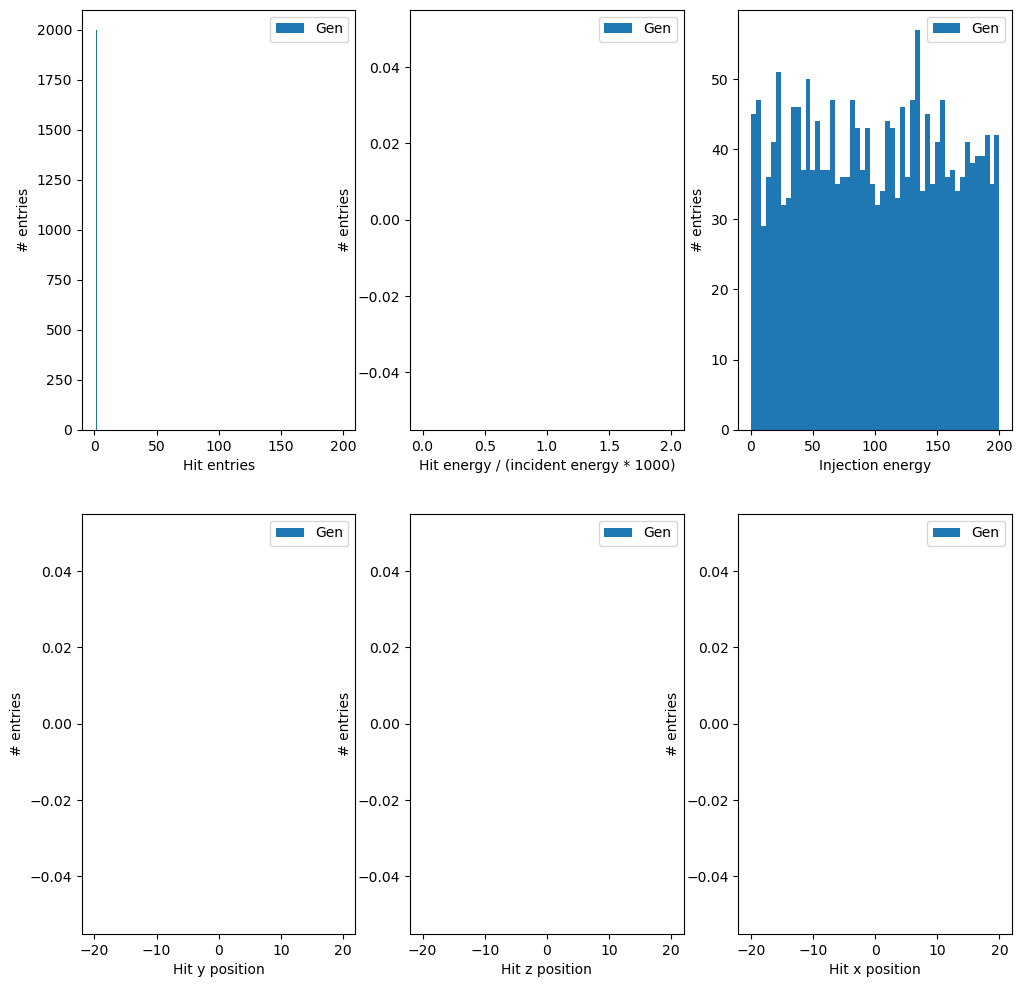

In [24]:
#from display_result import summarize_result
from scipy.linalg import sqrtm
import torch


#fig.savefig("generated_events.png")

#samples=torch.load('sampling/XYZEnormalized_0712_generated_samples.pt')


#dataloader = DataLoader(samples, batch_size=batch_size, shuffle=False)


def summarize_result1(samples, energy, threshold=-2000, label = ""):
    
    global all_x_g
    all_x_g =[]
    global all_y_g 
    all_y_g = []
    global all_z_g 
    all_z_g = []
    global all_e_g 
    all_e_g = []
    entries = []
    inject_energy = []
    lin=np.linspace(0,20,10000,endpoint=True)
    print("this is new")
    
    

    for i, data in enumerate(samples,0):
        
        valid_event = []
        data_np   = data.cpu().numpy().copy()
        energy_np = energy.cpu().numpy().copy()
        #print(data[:,0])
        mask = True #data_np[:,3] > -2000
        valid_event = data_np[mask]

        if len(valid_event) == 0:
            continue
        valid_event = np.array(valid_event)
        
        # data[:,0]=torch.FloatTensor([(float(i))*(torch.max(data[:,0])-torch.min(data[:,0]))+torch.min(data[:,0])for i in (data_np).copy()[:,0].flatten().tolist() ])
        # data[:,1]=torch.FloatTensor([(float(i))*(torch.max(data[:,1])-torch.min(data[:,1]))+torch.min(data[:,1])for i in (data_np).copy()[:,1].flatten().tolist() ])
        # data[:,2]=torch.FloatTensor([(float(i))*(torch.max(data[:,2])-torch.min(data[:,2]))+torch.min(data[:,2])for i in (data_np).copy()[:,2].flatten().tolist() ])
        # data[:,3]=torch.FloatTensor([(float(i))*(torch.max(data[:,3])-torch.min(data[:,3]))+torch.min(data[:,3])for i in (data_np).copy()[:,3].flatten().tolist() ])
        
        # data[:,0]=torch.FloatTensor([(float(i)+0.5)*2*torch.std(data[:,0])+torch.mean(data[:,0]) for i in (data_np).copy()[:,0].flatten().tolist() ])
        # data[:,1]=torch.FloatTensor([(float(i)+0.5)*2*torch.std(data[:,1])+torch.mean(data[:,1]) for i in (data_np).copy()[:,1].flatten().tolist() ])
        # data[:,2]=torch.FloatTensor([(float(i)+0.5)*2*torch.std(data[:,2])+torch.mean(data[:,2]) for i in (data_np).copy()[:,2].flatten().tolist() ])
        # data[:,3]=torch.FloatTensor([(float(i)+0.5)*2*torch.std(data[:,3])+torch.mean(data[:,3]) for i in (data_np).copy()[:,3].flatten().tolist() ])

        
       
        all_e_g += ((data_np).copy()[:,0]).flatten().tolist()
        all_x_g += ((valid_event).copy()[:,1]).flatten().tolist()
        all_y_g += ((valid_event).copy()[:,2]).flatten().tolist()
        all_z_g += ((valid_event).copy()[:,3]).flatten().tolist()
        entries.append(len(valid_event))
        inject_energy.append(energy_np[i]) 
   
    

    all_e_g=transform_e.inverse_transform(torch.Tensor(all_e_g).reshape(-1,1)).flatten().tolist()
    all_x_g=transform_x.inverse_transform(torch.Tensor(all_x_g).reshape(-1,1)).flatten().tolist()
    all_y_g=transform_y.inverse_transform(torch.Tensor(all_y_g).reshape(-1,1)).flatten().tolist()
    all_z_g=transform_z.inverse_transform(torch.Tensor(all_z_g).reshape(-1,1)).flatten().tolist()
    fig, ax = plt.subplots(2,3, figsize=(12,12))
    
    # c=torch.FloatTensor(all_x_g)
    # d=(c<=15)
    # e=[]
    # e = c[d]
    # f=(e>=-15)
    # all_x_g=e[f]


    # c=torch.FloatTensor(all_y_g)
    # d=(c<=15)
    # e=[]
#     e = c[d]
#     f=(e>=-15)
#     all_y_g=e[f]
# # #print("test",torch.mean(all_x_g))

#     a=torch.FloatTensor(all_z_g)
#     b=(a<=20)
#     w=[]
#     w = a[b]
#     y=(w>=-20)
#     all_z_g=w[y]
# # #print("test",torch.mean(all_x_g))

#     c=torch.FloatTensor(all_e_g)
#     d=(c<=1)
#     e=[]
#     e = c[d]
#     f=(e>=-20)
#     all_e_g=e[f]
# #print("test",torch.mean(all_x_g))


    ax[0][0].set_ylabel('# entries')
    ax[0][0].set_xlabel('Hit entries')
    ax[0][0].hist(entries, 200, range=(0,200), label=label)
    ax[0][0].legend(loc='upper right')

    ax[0][1].set_ylabel('# entries')
    ax[0][1].set_xlabel('Hit energy / (incident energy * 1000)')
    ax[0][1].hist(all_e_g, 50, range=(0,2), label=label)
    ax[0][1].legend(loc='upper right')

    ax[0][2].set_ylabel('# entries')
    ax[0][2].set_xlabel('Injection energy')
    ax[0][2].hist(inject_energy, 50, range=(0,200), label=label)
    ax[0][2].legend(loc='upper right')

    ax[1][2].set_ylabel('# entries')
    ax[1][2].set_xlabel('Hit x position')
    ax[1][2].hist(all_x_g, 50, range=(-20,20), label=label)
    
    ax[1][2].legend(loc='upper right')

    ax[1][0].set_ylabel('# entries')
    ax[1][0].set_xlabel('Hit y position')
    ax[1][0].hist(all_y_g, 50, range=(-20,20), label=label)
    ax[1][0].legend(loc='upper right')

    ax[1][1].set_ylabel('# entries')
    ax[1][1].set_xlabel('Hit z position')
    ax[1][1].hist(all_z_g, 50, range=(-20,20), label=label)
    ax[1][1].legend(loc='upper right')
    fig.show()
    fig.savefig("test.png")
summarize_result1(samples, sampled_energies, threshold=-2000, label = "Gen")

c=torch.FloatTensor(all_x_g)
d=(c<=20)
e=[]
e = c[d]
f=(e>=-20)
all_x_g=e[f]


c=torch.FloatTensor(all_y_g)
d=(c<=20)
e=[]
e = c[d]
f=(e>=-20)
all_y_g=e[f]
# #print("test",torch.mean(all_x_g))

a=torch.FloatTensor(all_z_g)
b=(a<=20)
w=[]
w = a[b]
y=(w>=-20)
all_z_g=w[y]
# #print("test",torch.mean(all_x_g))

c=torch.FloatTensor(all_e_g)
d=(c<=0)
e=[]
e = c[d]
f=(e>=-20)
all_e_g=e[f]
#print("test",torch.mean(all_x_g))


def FID(all_e,all_x,all_y,all_z,all_e_g,all_x_g,all_y_g,all_z_g):
    all_x=torch.Tensor(all_x)
    all_y=torch.Tensor(all_y)
    all_z=torch.Tensor(all_z)
    all_e=torch.Tensor(all_e)
    all_x_g=torch.Tensor(all_x_g)
    all_y_g=torch.Tensor(all_y_g)
    all_z_g=torch.Tensor(all_z_g)
    all_e_g=torch.Tensor(all_e_g)
    data1_x_mean=torch.mean(all_x)
    data1_y_mean=torch.mean(all_y)
    data1_z_mean=torch.mean(all_z)
    data2_x_mean=torch.mean(torch.Tensor(all_x_g))
    data2_y_mean=torch.mean(all_y_g)
    data2_z_mean=torch.mean(all_z_g)
    energy1_mean=torch.mean(all_e)
    energy2_mean=torch.mean(all_e_g)
    xe_covariance=0
    xy_covariance=0
    xz_covariance=0
    ye_covariance=0
    yz_covariance=0
    ez_covariance=0
    for i in range(len(all_x)):
        xy_covariance+=(all_x[i]-data1_x_mean)*(all_y[i]-data1_y_mean)
    xy_covariance=xy_covariance/len(all_x)
    for i in range(len(all_x)):
        xe_covariance+=(all_x[i]-data1_x_mean)*(all_e[i]-energy1_mean)
    xe_covariance=xe_covariance/len(all_x)
    for i in range(len(all_x)):
        xz_covariance+=(all_x[i]-data1_x_mean)*(all_z[i]-data1_z_mean) 
    xz_covariance=xz_covariance/len(all_x)
    for i in range(len(all_y)):
        yz_covariance+=(all_z[i]-data1_z_mean)*(all_y[i]-data1_y_mean)   
    yz_covariance=yz_covariance/len(all_y)
    for i in range(len(all_y)):
        ye_covariance+=(all_e[i]-energy1_mean)*(all_y[i]-data1_y_mean)   
    ye_covariance=ye_covariance/len(all_y)
    for i in range(len(all_e)):
        ez_covariance+=(all_e[i]-energy1_mean)*(all_z[i]-data1_z_mean)  
    ez_covariance=ez_covariance/len(all_e)

    xe_covariance2=0
    xy_covariance2=0
    xz_covariance2=0
    ye_covariance2=0
    yz_covariance2=0
    ez_covariance2=0
    '''
    for i in range(len(data2[:][:][1])):
        for j in range(len(data2[1][:][1])):
            xy_covariance2+=(data2[i][j][1]-data2_x_mean)*(data2[i][j][2]-data2_y_mean)
    xy_covariance2=xy_covariance2/len(data2[:][:][1])/len(data2[1][:][1])
    for i in range(len(data2[:][:][1])):
        for j in range(len(data2[1][:][1])):
            xe_covariance2+=(data2[i][j][1]-data2_x_mean)*(data2[i][j][0]-energy2_mean)
    xe_covariance2=xe_covariance2/len(data2[:][:][1])/len(data2[1][:][1])
    for i in range(len(data2[:][:][1])):
        for j in range(len(data2[1][:][1])):
            xz_covariance2+=(data2[i][j][1]-data2_x_mean)*(data2[i][j][3]-data2_z_mean) 
    xz_covariance2=xz_covariance2/len(data2[:][:][1])/len(data2[1][:][1])
    for i in range(len(data2[:][:][2])):
        for j in range(len(data2[1][:][2])):
            yz_covariance2+=(data2[i][j][3]-data2_z_mean)*(data2[i][j][2]-data2_y_mean)   
    yz_covariance2=yz_covariance2/len(data2[:][:][2])/len(data2[1][:][2])
    for i in range(len(data2[:][:][2])):
        for j in range(len(data2[1][:][2])):
            ye_covariance2+=(data2[i][j][0]-energy2_mean)*(data2[i][j][2]-data2_y_mean)   
    ye_covariance2=ye_covariance2/len(data2[:][:][2])/len(data2[1][:][2])
    for i in range(len(data2[:][:][0])):
        for j in range(len(data2[1][:][0])):
            ez_covariance2+=(data2[i][j][0]-energy2_mean)*(data2[i][j][3]-data2_z_mean)
    ez_covariance2=ez_covariance2/len(data2[:][:][0])/len(data2[1][:][0])
    '''

    for i in range(len(all_x_g)):
        xy_covariance2+=(all_x_g[i]-data2_x_mean)*(all_y_g[i]-data2_y_mean)
    xy_covariance2=xy_covariance2/len(all_x_g)
    for i in range(len(all_x_g)):
        xe_covariance2+=(all_x_g[i]-data2_x_mean)*(all_e_g[i]-energy2_mean)
    xe_covariance2=xe_covariance2/len(all_x_g)
    for i in range(len(all_x_g)):
        xz_covariance2+=(all_x_g[i]-data2_x_mean)*(all_z_g[i]-data2_z_mean) 
    xz_covariance2=xz_covariance2/len(all_x_g)
    for i in range(len(all_y_g)):
        yz_covariance2+=(all_z_g[i]-data2_z_mean)*(all_y_g[i]-data2_y_mean)   
    yz_covariance2=yz_covariance2/len(all_y_g)
    for i in range(len(all_y_g)):
        ye_covariance2+=(all_e_g[i]-energy2_mean)*(all_y_g[i]-data2_y_mean)   
    ye_covariance2=ye_covariance2/len(all_y_g)
    for i in range(len(all_e_g)):
        ez_covariance2+=(all_e_g[i]-energy2_mean)*(all_z_g[i]-data2_z_mean)  
    ez_covariance2=ez_covariance2/len(all_e_g)

    data1_x_std=torch.std(all_x)
    data1_y_std=torch.std(all_y)
    data1_z_std=torch.std(all_z)
    data2_x_std=torch.std(all_x_g)
    data2_y_std=torch.std(all_y_g)
    data2_z_std=torch.std(all_z_g)
    energy1_std=torch.std(all_e)
    energy2_std=torch.std(all_e_g)

    covariance_matrix1=[[energy1_std**2,xe_covariance,ye_covariance,ez_covariance],[xe_covariance,data1_x_std**2,xy_covariance,xz_covariance],[ye_covariance,xy_covariance,data1_y_std**2,yz_covariance],[ez_covariance,xz_covariance,yz_covariance,data1_z_std**2]]
    covariance_matrix2=[[energy2_std**2,xe_covariance2,ye_covariance2,ez_covariance2],[xe_covariance2,data2_x_std**2,xy_covariance2,xz_covariance2],[ye_covariance2,xy_covariance2,data2_y_std**2,yz_covariance2],[ez_covariance2,xz_covariance2,yz_covariance2,data2_z_std**2]]
    
    print(data1_x_mean)
    print(data1_y_mean)
    print(data1_z_mean)
    print(energy1_mean)
    print('data2_x_mean',data2_x_mean)
    print(data2_y_mean)
    print(data2_z_mean)
    print(energy2_mean)
    print('std',data1_x_std)
    print(data1_y_std)
    print(data1_z_std)
    print(energy1_std)
    print(data2_x_std)
    print(data2_y_std)
    print(data2_z_std)
    print(energy2_std)
    print(covariance_matrix1)
    print(covariance_matrix2)
    
    mean=(torch.abs(data1_x_mean-data2_x_mean)+torch.abs(data1_y_mean-data2_y_mean)+torch.abs(data1_z_mean-data2_z_mean)+torch.abs(energy1_mean-energy2_mean))
    std=(data1_x_std**2+data1_y_std**2+data1_z_std**2+data2_x_std**2+data2_y_std**2+\
                data2_z_std**2+energy1_std**2+energy2_std**2-2*(np.trace(sqrtm(np.matmul(covariance_matrix1,covariance_matrix2)))))
    return (mean+std)


def FID1(data1, data2):
    print(len(data2[0][0]))
    b = torch.Tensor(10000, 150, 4)
    torch.cat(data1, out=b)
    print(b.size())
    print(data2.dtype)
    data1 = b  # Convert to PyTorch tensor if not already

    data1_mean = torch.mean(data1[:, :, 1:])
    data2_mean = torch.mean(data2[:, :, 1:])
    energy1_mean = torch.mean(data1[:, :, 0])
    energy2_mean = torch.mean(data2[:, :, 0])

    data1_cov = torch.cov(data1.view(-1, 4).T)
    data2_cov = torch.cov(data2.view(-1, 4).T)

    diff_mean = torch.abs(data1_mean - data2_mean)
    diff_cov = torch.trace(data1_cov + data2_cov - 2 * sqrtm(torch.matmul(data1_cov, data2_cov)))

    fid = torch.norm(diff_mean) + diff_cov
    return fid.item()  # Return the FID value as a Python float

def FID2(all_e,all_x,all_y,all_z,all_e_g,all_x_g,all_y_g,all_z_g):
    all_x=torch.Tensor(all_x)
    all_y=torch.Tensor(all_y)
    all_z=torch.Tensor(all_z)
    all_e=torch.Tensor(all_e)
    all_x_g=torch.Tensor(all_x_g)
    all_y_g=torch.Tensor(all_y_g)
    all_z_g=torch.Tensor(all_z_g)
    all_e_g=torch.Tensor(all_e_g)
    data1_x_mean=torch.mean(all_x)
    data1_y_mean=torch.mean(all_y)
    data1_z_mean=torch.mean(all_z)
    data2_x_mean=torch.mean(torch.Tensor(all_x_g))
    data2_y_mean=torch.mean(all_y_g)
    data2_z_mean=torch.mean(all_z_g)
    energy1_mean=torch.mean(all_e)
    energy2_mean=torch.mean(all_e_g)
    data1_x_std=torch.std(all_x)
    data1_y_std=torch.std(all_y)
    data1_z_std=torch.std(all_z)
    data2_x_std=torch.std(all_x_g)
    data2_y_std=torch.std(all_y_g)
    data2_z_std=torch.std(all_z_g)
    energy1_std=torch.std(all_e)
    energy2_std=torch.std(all_e_g)
    print("FID of x :",torch.abs(data1_x_mean-data2_x_mean)**2+torch.abs(data1_x_std-data2_x_std)**2)
    print("FID of y :",torch.abs(data1_y_mean-data2_y_mean)**2+torch.abs(data1_y_std-data2_y_std)**2)
    print("FID of z :",(data1_z_mean-data2_z_mean)**2+(data1_z_std-data2_z_std)**2)
    print("FID of e :",(energy1_mean-energy2_mean)**2+(energy1_std-energy2_std)**2)
    print("x1mean",data1_x_mean)
    print("y1mean",data1_y_mean)
    print("z1mean",data1_z_mean)
    print("e1mean",energy1_mean)
    print('data2_x_mean',data2_x_mean)
    print("y2mean",data2_y_mean)
    print("z2mean",data2_z_mean)
    print("e2mean",energy2_mean)
    print('x1std',data1_x_std)
    print('y1std',data1_y_std)
    print('z1std',data1_z_std)
    print('e1std',energy1_std)
    print('x2std',data2_x_std)
    print('y2std',data2_y_std)
    print('z2std',data2_z_std)
    print('e2std',energy2_std)
#print(training_dataset.size())
FID2(original_energy,original_x[:173993],original_y[:173993],original_z,all_e_g,all_x_g,all_y_g,all_z_g)
#print(FID1(training_dataset,samples))


In [26]:

import time, functools, torch, os, random, fnmatch, psutil, argparse
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, Adamax
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
#from trans_tdsm import Gen, loss_fn, pc_sampler
#import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D
import ignite
import torchvision.transforms as transforms
import torchvision.utils as vutils

from collections import OrderedDict
from ignite.metrics import FID, InceptionScore
import torch
from torch import nn, optim

from ignite.engine import Engine

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

# create default optimizer for doctests

#param_tensor = torch.zeros([1], requires_grad=True)
#default_optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# create default trainer for doctests
# as handlers could be attached to the trainer,
# each test must define his own trainer using `.. testsetup:`

def get_default_trainer():

    def train_step(engine, batch):
        return batch

    return Engine(train_step)

# create default model for doctests

default_model = nn.Sequential(OrderedDict([
    ('base', nn.Linear(1, 1))

]))

#print(default_model.weight.data)
    


#vector=torch.ones(173993,2)
#lin=nn.Linear(40,3)
#default_model.weight.data=torch.FloatTensor(vector.T)
#print(lin.weight.data)

#print(default_model(torch.FloatTensor(original_x[:182574])))

#manual_seed(666)
torch.manual_seed(666)
#torch.backends.cudnn.benchmark = False

test_true = torch.ones(182574)
test_pred = torch.zeros(182574)

demo=nn.Linear(1, 1)
print(demo.weight.data)
metric = FID(num_features=1,feature_extractor=demo )
metric.attach(default_evaluator, "fid")
y_true = original_x[:173993]
y_true=torch.FloatTensor(original_x[:173993])
y_true=y_true.reshape(-1,1)
y_pred = original_x[:173993]
print(len(all_x))
print(len(all_x_g))
#c = torch.Tensor(np.vstack((y_pred, y_true)))
x_true = torch.FloatTensor(all_x_g)
x_true=x_true.reshape(-1,1)
x_pred = all_x_g
#combine = torch.Tensor(np.vstack((x_pred, x_true)))
#y1_true = original_y[:174245]
y1_true=torch.FloatTensor(original_y[:173993])
y1_true=y1_true.reshape(-1,1)
y1_pred = original_y[:173993]
print(len(all_x))
print(len(all_x_g))
#c1 = torch.Tensor(np.vstack((y1_pred, y1_true)))
x1_true = all_y_g
x1_pred = all_y_g
x1_true=torch.FloatTensor(all_y_g)
x1_true=y_true.reshape(-1,1)
#combine1 = torch.Tensor(np.vstack((x1_pred, x1_true)))
print(c)
#print(combine)
state = default_evaluator.run([[y1_true,x1_true]])
print(FID.compute(y1_true,x1_true))
print(state.metrics["fid"])




tensor([[-0.3762]])
752887
174206
752887
174206
tensor([0.0283, 0.4996, 0.6731,  ..., 0.3559, 0.2066, 0.1337])


RuntimeError: Decorator sync_all_reduce should be used on ignite.metric.Metric class methods only

In [47]:
# QuantileTransformer_e=all_e_tensor
# QuantileTransformer_x=all_x_tensor
# QuantileTransformer_y=all_y_tensor
# QuantileTransformer_z=all_z_tensor
# QuantileTransformer_e_g=all_e_g
# QuantileTransformer_x_g=all_x_g
# QuantileTransformer_y_g=all_y_g
# QuantileTransformer_z_g=all_z_g

RobustScaler_e=all_e_tensor
RobustScaler_x=all_x_tensor
RobustScaler_y=all_y_tensor
RobustScaler_z=all_z_tensor
RobustScaler_e_g=all_e_g
RobustScaler_x_g=all_x_g
RobustScaler_y_g=all_y_g
RobustScaler_z_g=all_z_g

In [26]:
print(samples[0])

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [n